# Preprocessing datasets

Para execução deste jupyter é recomendado a utilização da ambiente docker pysus localizado no repositório do github [AlertaDengue](https://github.com/AlertaDengue/PySUS). O repositório encontra-se disponível localmente no caminho `./code/PySUS` deste projeto commit `83ff70972602108cb73395743fab52a62f53cd29`.

## 1. Import packages

Comando para instalação de bibliotecas que não estão contempladas em __PySUS__

In [4]:
!conda install -c conda-forge utm -y
!conda install -c conda-forge missingno -y
!conda install pytables -y
!pip install simpledbf
!pip install git+https://github.com/mstuttgart/pycep-correios.git@develop

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda/envs/master-ds

  added / updated specs:
    - utm


The following packages will be UPDATED:

  ca-certificates     pkgs/main::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi              pkgs/main::certifi-2020.4.5.1-py38_0 --> conda-forge::certifi-2020.4.5.1-py38h32f6830_0
  openssl              pkgs/main::openssl-1.1.1f-h7b6447c_0 --> conda-forge::openssl-1.1.1f-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda/envs/master-ds

  added / updated specs:
    - pytables


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certifi

In [1]:
from description import resp_diseases, diseases_cols
from description import cities_mrs, cities_cols
from description import unused_cols

# from pysus.utilities.readdbc import read_dbc
from IPython.display import Image
from simpledbf import Dbf5

import multiprocessing as mp
import pycep_correios as pc
import missingno as msno
import pandas as pd
import numpy as np
import requests
# import xlrd
import glob
import utm
import os
import re

SQLalchemy is not installed. No support for SQL output.


## 2. Global variables

### 2.1 General

Variáveis utilizadas para indicar o caminho onde os dados (csv) estão armazenados.

_AIRQ foi fornecido com granularidade de 1h e 15min, basta substituir para selecionar o desejado._

In [76]:
# Paths
PATHS = dict(
    IN = '../datas/raw/mr-ssa',
    OUT = '../datas/preprocessing/mr-ssa',
    IMG = '../docs/images',
) 

# Folders
FOLDERS = dict(
    DESC = 'datasus/description',
    AIRQ = 'airquality/cetrel/interval_1hour', # interval_15min ou interval_1hour
    WTHR = 'weather/cetrel',
    DSUS = 'datasus'
)

### 2.2 Weather and Air quality (Stations)

Imagens utilizadas para identificar onde as estações de monitoramento da CETREL estão localizadas e UTM Zone para conversão das coordenadas.

_A localização da estação na AV. BARROS REIS foi obtida manualmente._

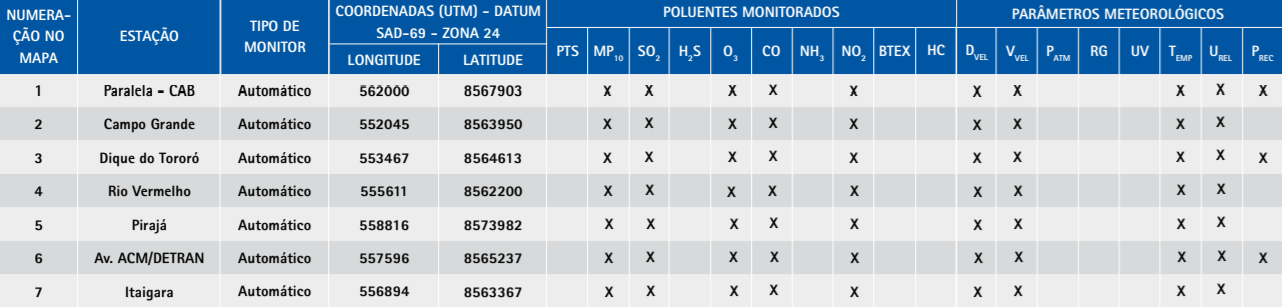

'fonte: https://www.icict.fiocruz.br/sites/www.icict.fiocruz.br/files/Diagnostico_Rede_de_Monitoramento_da_Qualidade_do_Ar.pdf'

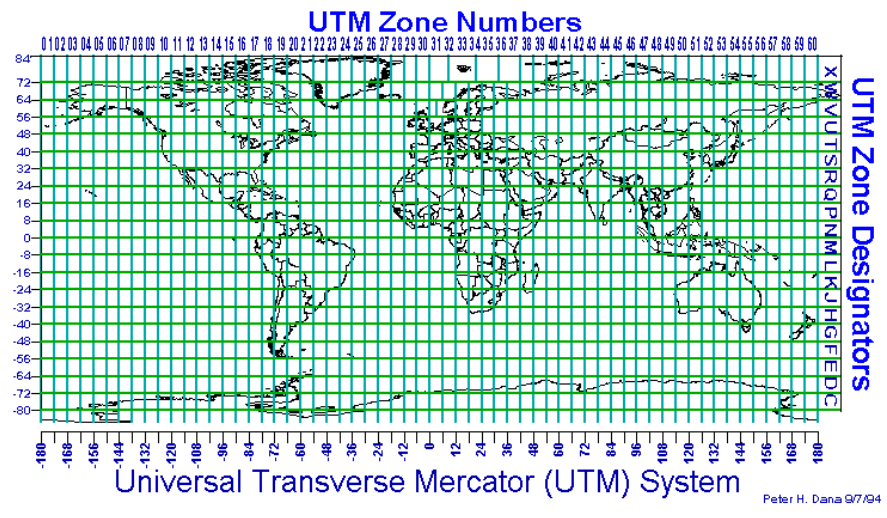

'fonte: http://www.jaworski.ca/utmzones.htm'

In [3]:
display(
    Image(filename=f"{PATHS['IMG']}/coords_stations.png"),
    'fonte: https://www.icict.fiocruz.br/sites/www.icict.fiocruz.br/files/Diagnostico_Rede_de_Monitoramento_da_Qualidade_do_Ar.pdf',
    Image(filename=f"{PATHS['IMG']}/utm.png"),
    'fonte: http://www.jaworski.ca/utmzones.htm'
)

Extração e conversão das coordenadas das estações existentes no conjunto de dados fornecidos pela CETREL

In [4]:
COORDS = {
    'PARALELA-CAB': {'easting': 562000,'northing': 8567903},
    'CAMPO GRANDE': {'easting': 552045,'northing': 8563950},
    'DIQUE DO TORORÓ': {'easting': 553467,'northing': 8564613},
    'RIO VERMELHO': {'easting': 555611,'northing': 8562200},
    'PIRAJÁ': {'easting': 558816,'northing': 8573982},
    'AV ACM - DETRAN': {'easting': 557596,'northing': 8565237},
    'ITAIGARA': {'easting': 556894,'northing': 8563367},
    'AV BARROS REIS': {'easting': 556471,'northing': 8566760},
}

for st in COORDS:
    coord = utm.to_latlon(COORDS[st]['easting'], COORDS[st]['northing'], 24, 'L')
    COORDS[st] = {'lat': coord[0], 'lon': coord[1]}

display(COORDS)

{'PARALELA-CAB': {'lat': -12.95380923791381, 'lon': -38.4283765135188},
 'CAMPO GRANDE': {'lat': -12.989739074988103, 'lon': -38.520087964258316},
 'DIQUE DO TORORÓ': {'lat': -12.983719430807755, 'lon': -38.506987720873795},
 'RIO VERMELHO': {'lat': -13.005500404304225, 'lon': -38.487173939040254},
 'PIRAJÁ': {'lat': -12.89890346602677, 'lon': -38.45784983333805},
 'AV ACM - DETRAN': {'lat': -12.97800204250844, 'lon': -38.468927832478045},
 'ITAIGARA': {'lat': -12.994924360695752, 'lon': -38.47536505282404},
 'AV BARROS REIS': {'lat': -12.964251495523227, 'lon': -38.47932939716548}}

## 3. Functions

Função para exibição de uma lista enumerada

- arr: lista a ser enumerada

return: retorna uma lista enumerada (dicionário)

In [5]:
def show_enum(arr: [str]) -> {int: str}:
    return {idx: value for (idx, value) in enumerate(arr)}

Função para filtrar o dataframe com a busca de um conjunto de valores em suas colunas utilizando a operação OR

- df: dataframe para busca
- cols: colunas a serem investigadas
- values: conjunto de valores a serem buscados

return: retorna o dataframe filtrado ou sem completo, caso não encontre nenhum valor

In [6]:
def _filter(df: pd.DataFrame, cols: [str], values: [str]) -> pd.DataFrame:
    f = [False]
    for cc in cols:
        try:
            aux = df[cc].isin(values)
            f |= aux
        except KeyError:
            pass
    
    return df if len(f) == 1 else df[f]

Função para deletar colunas dos dataframe

- df: dataframe para exclusão
- cols: colunas a serem excluídas

In [7]:
def drop_cols(df: pd.DataFrame, cols: [str]) -> None:
    for c in cols:
        try:
            df.drop(c, inplace=True, axis=1)
        except KeyError:
            pass

Função para remover valores branco em uma lista

- row: lista para excluir

return: retorna a lista sem valores vazios

In [8]:
def drop_empty(row: [str]) -> [str]:
    return [c for c in row if c != '']

Função para converter strings para inteiros no conjunto de arquivos

- files: arquivos a serem removidos
- index: coluna índice

In [9]:
def string2int(files: [str], index: str = 'Date & Time') -> None:
    for file in files:
        df = pd.read_csv(file, index_col=index, compression='gzip')
        df = df.apply(pd.to_numeric, errors='coerce')
        df.to_csv(file, compression='gzip')
        print(f'[DONE] {file}')

Função para concatenar todas estações em um único arquivo

- files: lista de arquivos para concatenar
- coords: lista de coordenadas - {stations: {lat, lon}}
- out: caminho para o arquivo de saída
- keep_old: True - os arquivos anteriores serão removidos, False - mantém os arquivos originais

In [10]:
def merger_stations(
    files: [str], coords: {str: {}}, out: str, keep_old: bool = False
) -> None:
    df = pd.DataFrame()
    for file in files:
        station = file.split('/')[-1][:-7]

        aux = pd.read_csv(file, compression='gzip')
        aux['station'] = station
        aux['lat'] = coords[station]['lat']
        aux['lon'] = coords[station]['lon']

        df = pd.concat([df, aux], sort=False, ignore_index=True)

        if not keep_old:
            os.remove(file)
            print(f'[INFO] {file} removed')
        
    df.to_csv(out, index=False, compression='gzip')
    print(f'[DONE] {out}')

Função para buscar o hospital a partir do CNES em uma tupla do dataframe

- row: identificador da tupla
- df: dataframe para busca
- df_cnes: dataframe com a lista de CNES

return: retorna a tupla (row) com o hospital adicionado, se localizado.

In [11]:
def get_hospital(
    row: int, df: pd.DataFrame, df_cnes: pd.DataFrame
) -> pd.DataFrame:
    aux = df.loc[[row]]
    cnes = str(aux.loc[row, 'CNES'])
    hosp = df_cnes.loc[df_cnes['CHAVE'] == cnes]
    if not hosp.empty:
        aux.loc[row, 'HOSP'] = hosp.iloc[0]['DS_REGRA']
        
    return aux

Função alternativa ao pycep_correios para capturar endereços pelo cep.

- cep: código do cep

_Para utilizar o webmaniabr é necessário se cadastrar na plataforma para gerar os tokens de acesso. O token pode ser adicionado substituindo os campos abaixo ou adicionados em um arquivo `env`._

return: retorna o json da requisição

In [12]:
import env

def get_address(cep) -> {}:
    api = (
        'https://webmaniabr.com/api/1/cep/{}/'
        f'?app_key={env.app_key}'
        f'&app_secret={env.app_secret}'
    )
    return requests.get(api.format(cep)).json()

# def get_address(cep) -> {}:
#     api = "http://apps.widenet.com.br/busca-cep/api/cep/{}.json"
#     return requests.get(api.format(cep)).json()

Função para processar um dataframe adicionando o bairro a partir do CEP, se encontrado, e o município, a partir do código do município

- row: identificador da tupla
- df: dataframe de processamento

return: retorna a tupla (row) com o endereço adicionado

In [13]:
def process_addr(row: int, df: pd.DataFrame) -> pd.DataFrame:
    aux = df.loc[[row]]
    cep = str(aux.loc[row, 'CEP'])
#     addr = pc.get_address_from_cep(cep) # site down (caution)
    addr = get_address(cep) # blocked by flood (caution)

    aux.loc[row, 'BAIRRO_RES'] = addr.get('bairro', '')
    
    id_city = str(aux.loc[row, 'MUNIC_RES'])
    aux.loc[row, 'MUNIC_RES'] = cities_mrs.get(id_city, id_city)
    
    id_city = str(aux.loc[row, 'MUNIC_MOV'])
    aux.loc[row, 'MUNIC_MOV'] = cities_mrs.get(id_city, id_city)
        
    return aux

Função para formatar a hora para o padrão 0~23

- file: path para o arquivo ao qual deseja formatar
- hour_col: coluna indicando a hora
- out: path para o arquivo de saída

In [80]:
def date_format(file: str, hour_col: str, out: str) -> None:
    df = pd.read_csv(file, low_memory=False, compression='gzip')
    df[hour_col] = df[hour_col].apply(lambda hr: re.sub(r"24:00", "00:00", hr))
    df.to_csv(out, index=False, compression='gzip')

## 4. Air quality - preprocessing

### 4.1 [CETREL] Get air quality excel files

Listando os arquivos de qualidade do ar brutos.

In [12]:
path = f"{PATHS['IN']}/{FOLDERS['AIRQ']}/*.xlsx"
f_airq = glob.glob(path)
show_enum(f_airq)

{0: '../datas/raw/mr-ssa/airquality/cetrel/interval_1hour/Monitoramento Salvador - 2011.xlsx',
 1: '../datas/raw/mr-ssa/airquality/cetrel/interval_1hour/Monitoramento Salvador - 2012.xlsx',
 2: '../datas/raw/mr-ssa/airquality/cetrel/interval_1hour/Monitoramento Salvador - 2013.xlsx',
 3: '../datas/raw/mr-ssa/airquality/cetrel/interval_1hour/Monitoramento Salvador - 2014.xlsx',
 4: '../datas/raw/mr-ssa/airquality/cetrel/interval_1hour/Monitoramento Salvador - 2015.xlsx',
 5: '../datas/raw/mr-ssa/airquality/cetrel/interval_1hour/Monitoramento Salvador - NO.xlsx'}

### 4.2 [CETREL] Generating csv

#### [15min]

Processando os dados com granularidade de 15min para obter em formato CSV

In [4]:
for file in f_airq:
    print(f'\nStarting {file}')

    # Open excel file
    wb = xlrd.open_workbook(file)

    # Get station name
    station = file.split('/')[-1]
    station = station[:-5]

    # Get all sheets
    sheet_names = wb.sheet_names()

    for sheet_name in sheet_names:
        # Get sheet
        sheet = wb.sheet_by_name(sheet_name)

        # Rows number
        nrows = sheet.nrows

        # Get cols names
        cols = sheet.row_values(2)

        # Get units
        units = sheet.row_values(3)

        # Concatenate cols with units except cols[0] (date & time)
        cols[1:] = [f'{cols[i]} ({units[i]})' for i in range(1, len(cols))]

        # Init dataframe
        df = pd.DataFrame(columns=cols)

        # Get only valid datas
        for r in range(4, nrows-8):
            aux = pd.DataFrame([sheet.row_values(r)], columns=cols)
            df = pd.concat([df, aux], ignore_index=True)

        # Generate output name
        f_out = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/{station}-{sheet_name}"

        # Generate gzip output file
        df.to_csv(f'{f_out}.csv.gz', index=False, compression='gzip')

        print(f'[DONE] {f_out}.csv.gz')

    print(f'Ending {file}\n')
print('Ending all.')


Starting ../datas/raw/mr-ssa/airquality/av-acm-detran.xlsx
[DONE] ../datas/preprocessing/mr-ssa/airquality/av-acm-detran-2013.zip
[DONE] ../datas/preprocessing/mr-ssa/airquality/av-acm-detran-2014.zip
[DONE] ../datas/preprocessing/mr-ssa/airquality/av-acm-detran-2015.zip
Ending ../datas/raw/mr-ssa/airquality/av-acm-detran.xlsx


Starting ../datas/raw/mr-ssa/airquality/barros-reis.xlsx
[DONE] ../datas/preprocessing/mr-ssa/airquality/barros-reis-2013.zip
[DONE] ../datas/preprocessing/mr-ssa/airquality/barros-reis-2014.zip
[DONE] ../datas/preprocessing/mr-ssa/airquality/barros-reis-2015.zip
Ending ../datas/raw/mr-ssa/airquality/barros-reis.xlsx


Starting ../datas/raw/mr-ssa/airquality/campo-grande.xlsx
[DONE] ../datas/preprocessing/mr-ssa/airquality/campo-grande-2013.zip
[DONE] ../datas/preprocessing/mr-ssa/airquality/campo-grande-2014.zip
[DONE] ../datas/preprocessing/mr-ssa/airquality/campo-grande-2015.zip
Ending ../datas/raw/mr-ssa/airquality/campo-grande.xlsx


Starting ../datas/raw

#### [1hour]

Processando os dados com granularidade de 15min para obter em formato CSV

In [ ]:
for file in f_airq:
    print(f'\nStarting {file}')

    # Open excel file
    wb = xlrd.open_workbook(file)

    # Get complement in file name
    complement = file.split('- ')[-1]
    complement = complement[:-5]

    # Get all sheets (stations)
    sheet_names = wb.sheet_names()

    for station in sheet_names:
        # Get sheet (station)
        sheet = wb.sheet_by_name(station)

        # Rows number
        nrows = sheet.nrows

        # Get cols names
        cols = sheet.row_values(10)
        cols[0] = "Date & Time"
        cols = drop_empty(cols)

        # Get units
        units = sheet.row_values(11)

        # Concatenate cols with units except cols[0] (date & time)
        cols[1:] = [f'{cols[i]} ({units[i]})' for i in range(1, len(cols))]

        # Init dataframe
        df = pd.DataFrame(columns=cols)

        # Get only valid datas
        for r in range(12, nrows-8):
            aux = pd.DataFrame([drop_empty(sheet.row_values(r))], columns=cols)
            df = pd.concat([df, aux], ignore_index=True)
            
        # Generate output name
        f_out = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/{station}-{complement}"

        # Generate gzip output file
        df.to_csv(f'{f_out}.csv.gz', index=False, compression='gzip')

        print(f'[DONE] {f_out}.csv.gz')

    print(f'Ending {file}\n')
print('Ending all.')

#### [1hour] merging

Concatenando todos os anos e emissão de NO em um único arquivo para cada estação.

In [14]:
# Get all stations
path = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/*-20*.gz"
stations = np.unique([f[:-12].split('/')[-1] for f in glob.glob(path)])
stations

array([], dtype=float64)

In [46]:
# Process for each station
for station in stations:
    print(f'\nStarting {station}')
    
    path = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/{station}-20*.gz"
    f_airq = glob.glob(path)
    
    no = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/{station}-NO*.gz"
    f_no = glob.glob(no)
    
    print('[INFO] Merging years')
    df = pd.DataFrame()
    for file in f_airq:
        aux = pd.read_csv(file, index_col='Date & Time', compression='gzip')
        df = pd.concat([df, aux])
        os.remove(file)
        print(f'[INFO] {file} removed')

    print('[INFO] Merging NO specie')
    for file in f_no:
        aux = pd.read_csv(file, index_col='Date & Time', compression='gzip')
        df = df.join(aux, on='Date & Time')
        os.remove(file)
        print(f'[INFO] {file} removed')
            
    # Generate output name
    f_out = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/{station}"
            
    # Generate gzip output file
    df.to_csv(f'{f_out}.csv.gz', compression='gzip')

    print(f'[DONE] {f_out}.csv.gz')

    print(f'Ending {station}\n')
print('Ending all.')


Starting AV ACM - DETRAN
[INFO] Merging years
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV ACM - DETRAN-2013.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV ACM - DETRAN-2014.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV ACM - DETRAN-2015.csv.gz removed
[INFO] Merging NO specie
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV ACM - DETRAN-NO.csv.gz removed
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV ACM - DETRAN.csv.gz
Ending AV ACM - DETRAN


Starting AV BARROS REIS
[INFO] Merging years
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV BARROS REIS-2013.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV BARROS REIS-2014.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV BARROS REIS-2015.csv.gz removed
[INFO] Merging NO specie
[IN

#### [1hour] format columns (removes strings)

Foi identificado que existem registros com strings, com indicadores de problema no equipamento, superaquecimento, etc. Esses registros foram substituidos por NaN.

In [72]:
path = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/*.gz"
f_airq = glob.glob(path)
f_airq

['../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/airquality.csv.gz']

In [18]:
string2int(f_airq)

[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV ACM - DETRAN.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV BARROS REIS.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/CAMPO GRANDE.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/DIQUE DO TORORÓ.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/ITAIGARA.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/PARALELA-CAB.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/PIRAJÁ.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/RIO VERMELHO.csv.gz


#### [1hour] Merging all stations with coordinates

Concatenando todas estações em um único arquivo, adicionando como identificadores:

- nome da estação
- coordenadas [lat, lon]

In [187]:
f_out = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/airquality.csv.gz"
merger_stations(f_airq, COORDS, f_out)

[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV ACM - DETRAN.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/AV BARROS REIS.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/CAMPO GRANDE.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/DIQUE DO TORORÓ.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/ITAIGARA.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/PARALELA-CAB.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/PIRAJÁ.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/RIO VERMELHO.csv.gz removed
[DONE] ../datas/preprocessing/mr-ssa/airquality/cetrel/interval_1hour/airquality.csv.gz


#### [1hour] Format datetime

Formatando a data para substituir o valor 24h por 0h, mantendo o padrão.

In [81]:
f_out = f"{PATHS['OUT']}/{FOLDERS['AIRQ']}/airquality.csv.gz"
date_format(f_out, 'Date & Time', f_out)

## 5. Weather - preprocessing

### 5.1 [CETREL] Get weather excel files

Listando arquivos com os dados meteorológicos

In [30]:
path = f"{PATHS['IN']}/{FOLDERS['WTHR']}/*.xls"
f_wthr = glob.glob(path)
show_enum(f_wthr)

{0: '../datas/raw/mr-ssa/weather/cetrel/rmar-2013.xls',
 1: '../datas/raw/mr-ssa/weather/cetrel/rmar-2014.xls',
 2: '../datas/raw/mr-ssa/weather/cetrel/rmar-2015.xls'}

### 5.2 [CETREL] Generating csv

Gerando um csv para cada estação, extraida a partir dos dados de entrada

In [6]:
for file in f_wthr:
    print(f'\nStarting {file}')

    # Open excel file
    wb = xlrd.open_workbook(file)

    # Get year
    year = file.split('/')[-1]
    year = year[-8:-4]

    # Get sheet
    sheet = wb.sheet_by_index(0)

    # Rows number
    nrows = sheet.nrows

    # Get cols names with counts
    stations = sheet.row_values(2, start_colx=1)
    stations_u = list(dict.fromkeys(stations))
    stations_c = { x: stations.count(x) for x in stations_u}

    index_col = sheet.cell_value(3,0)

    colx = dict(start_colx=1, end_colx=0)
    for st in stations_c:
        colx['end_colx'] = colx['start_colx'] + stations_c[st]

        # Get cols names
        cols = [index_col]
        cols.extend(sheet.row_values(3, **colx))

        # Get units
        units = sheet.row_values(4, **colx)

        # Concatenate cols with units
        for i in range(1, len(cols)):
            cols[i] = f'{cols[i]} ({units[i-1]})'

        # Init dataframe
        df = pd.DataFrame(columns=cols)

        # Get only valid datas
        for r in range(5, nrows-8):
            register = [sheet.cell_value(r, 0)]
            register.extend(sheet.row_values(r, **colx))
            aux = pd.DataFrame([register], columns=cols)
            df = pd.concat([df, aux], ignore_index=True)

        # Generate output name
        f_out = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/{st}-{year}.csv.gz"

        # Generate gzip output file
        df.to_csv(f_out, index=False, compression='gzip')

        colx['start_colx'] = colx['end_colx']
        print(f'[DONE] {f_out}')

    print(f'Ending {file}\n')
print('Ending all.') 


Starting ../datas/raw/mr-ssa/weather/rmar-2013.xls
[DONE] ../datas/preprocessing/mr-ssa/weather/AV. ACM - DETRAN-2013.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/AV. BARROS REIS-2013.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/CAMPO GRANDE-2013.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/DIQUE DO TORORO-2013.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/ITAIGARA-2013.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/PARALELA-CAB-2013.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/PIRAJA-2013.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/RIO VERMELHO-2013.csv.gz
Ending ../datas/raw/mr-ssa/weather/rmar-2013.xls


Starting ../datas/raw/mr-ssa/weather/rmar-2014.xls
[DONE] ../datas/preprocessing/mr-ssa/weather/AV. ACM - DETRAN-2014.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/AV. BARROS REIS-2014.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/CAMPO GRANDE-2014.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/DIQUE DO TORORO-2014.csv

### 5.3 [CETREL] Merging csv

Concatenando todos os índices anuais de cada estação em um único arquivo

In [14]:
path = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/*.gz"
stations = np.unique([f[:-12].split('/')[-1] for f in glob.glob(path)])
stations

array(['AV. ACM - DETRAN', 'AV. BARROS REIS', 'CAMPO GRANDE',
       'DIQUE DO TORORO', 'ITAIGARA', 'PARALELA-CAB', 'PIRAJA',
       'RIO VERMELHO'], dtype='<U16')

In [16]:
for station in stations:
    print(f'\nStarting {station}')
    
    path = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/{station}*.gz"
    f_airq = glob.glob(path)
    
    print('[INFO] Merging years')
    df = pd.DataFrame()
    for file in f_airq:
        aux = pd.read_csv(file, compression='gzip')
        df = pd.concat([df, aux])
        os.remove(file)
        print(f'[INFO] {file} removed')
            
    # Generate output name
    f_out = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/{station}"
            
    # Generate gzip output file
    df.to_csv(f'{f_out}.csv.gz', index=False, compression='gzip')

    print(f'[DONE] {f_out}.csv.gz')

    print(f'Ending {station}\n')
print('Ending all.')


Starting AV. ACM - DETRAN
[INFO] Merging years
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. ACM - DETRAN-2013.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. ACM - DETRAN-2014.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. ACM - DETRAN-2015.csv.gz removed
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. ACM - DETRAN.csv.gz
Ending AV. ACM - DETRAN


Starting AV. BARROS REIS
[INFO] Merging years
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. BARROS REIS-2013.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. BARROS REIS-2014.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. BARROS REIS-2015.csv.gz removed
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. BARROS REIS.csv.gz
Ending AV. BARROS REIS


Starting CAMPO GRANDE
[INFO] Merging years
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/CAMPO GRANDE-2013.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/

### 5.4 [CETREL] Format columns (removes strings)

Igualmente aos dados de qualidade do ar, foi identificado que existem registros com strings, com indicadores de problema no equipamento, superaquecimento, etc. Esses registros foram substituidos por NaN.

In [19]:
path = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/*.gz"
f_wthr = glob.glob(path)
f_wthr

['../datas/preprocessing/mr-ssa/weather/cetrel/AV. ACM - DETRAN.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/AV. BARROS REIS.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/CAMPO GRANDE.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/DIQUE DO TORORO.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/ITAIGARA.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/PARALELA-CAB.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/PIRAJA.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/RIO VERMELHO.csv.gz']

In [20]:
string2int(f_wthr)

[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. ACM - DETRAN.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/AV. BARROS REIS.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/CAMPO GRANDE.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/DIQUE DO TORORO.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/ITAIGARA.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/PARALELA-CAB.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/PIRAJA.csv.gz
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/RIO VERMELHO.csv.gz


### 5.5 [CETREL] Merging all stations with coordinates

Algumas estações estavam com a nomenclatura diferente dos dados de qualidade do ar. Com intuito de reaproveitamento de código, a célula abaixo renomeia os arquivos eposteriormente todas estações são concatenadas em um únicos arquivo, utilizando as mesma regras de identificação do dados de qualidade do ar:

- nome da estação
- coorndeadas [lat, lon]

In [151]:
# Rename files for usage same COORDS variable
!mv ../datas/preprocessing/mr-ssa/weather/cetrel/AV\.\ ACM\ \-\ DETRAN.csv.gz \
    ../datas/preprocessing/mr-ssa/weather/cetrel/AV\ ACM\ \-\ DETRAN.csv.gz
!mv ../datas/preprocessing/mr-ssa/weather/cetrel/AV\.\ BARROS\ REIS.csv.gz \
    ../datas/preprocessing/mr-ssa/weather/cetrel/AV\ BARROS\ REIS.csv.gz
!mv ../datas/preprocessing/mr-ssa/weather/cetrel/DIQUE\ DO\ TORORO.csv.gz \
    ../datas/preprocessing/mr-ssa/weather/cetrel/DIQUE\ DO\ TORORÓ.csv.gz
!mv ../datas/preprocessing/mr-ssa/weather/cetrel/PIRAJA.csv.gz \
    ../datas/preprocessing/mr-ssa/weather/cetrel/PIRAJÁ.csv.gz

In [223]:
path = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/*.gz"
f_wthr = glob.glob(path)
f_wthr

['../datas/preprocessing/mr-ssa/weather/cetrel/AV ACM - DETRAN.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/AV BARROS REIS.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/CAMPO GRANDE.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/DIQUE DO TORORÓ.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/ITAIGARA.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/PARALELA-CAB.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/PIRAJÁ.csv.gz',
 '../datas/preprocessing/mr-ssa/weather/cetrel/RIO VERMELHO.csv.gz']

In [224]:
f_out = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/weather.csv.gz"
merger_stations(f_wthr, COORDS, f_out)

[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV ACM - DETRAN.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/AV BARROS REIS.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/CAMPO GRANDE.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/DIQUE DO TORORÓ.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/ITAIGARA.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/PARALELA-CAB.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/PIRAJÁ.csv.gz removed
[INFO] ../datas/preprocessing/mr-ssa/weather/cetrel/RIO VERMELHO.csv.gz removed
[DONE] ../datas/preprocessing/mr-ssa/weather/cetrel/weather.csv.gz


### 5.6 Format datetime

Formatando a data para substituir o valor 24h por 0h, mantendo o padrão.

In [82]:
f_out = f"{PATHS['OUT']}/{FOLDERS['WTHR']}/weather.csv.gz"
date_format(f_out, 'Date & Time', f_out)

## 6. Datasus - preprocessing

### 6.1 Descriptions files

A descrição dos dados SIHSUS foram obtidos através do link [datasus](http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25). Onde:

- Documentação descreve as colunas presentes, mesma apresentação relizada na célula abaixo.
- Arquivos auxiliares de tabulação possuem a descrição dos identificadores presentes em algumas colunas. Estes arquivos podem ser visualizados com a ferramenta online [filext](https://filext.com/file-extension/CNV).

Ambos arquivos de descrição estão presentes no caminho do projeto `/docs/others`

### 6.2 AIH Reduzida (RD)

Descrição das colunas do SIHSUS. Em vermelho estão as colunas que não são interessantes para o estudo.

SEQ|NOME DO CAMPO|TIPO E TAM|Descrição/Observações
---|-------------|----------|---------------------
<span style="color:red">1|<span style="color:red">UF_ZI|<span style="color:red">char(6)|<span style="color:red">Município Gestor
<span style="color:red">2|<span style="color:red">ANO_CMPT|<span style="color:red">char(4)|<span style="color:red">Ano de processamento da AIH, no formato aaaa.
<span style="color:red">3|<span style="color:red">MÊS_CMPT|<span style="color:red">char(2)|<span style="color:red">Mês de processamento da AIH, no formato mm.
<span style="color:red">4|<span style="color:red">ESPEC|<span style="color:red">char(2)|<span style="color:red">Especialidade do Leito
<span style="color:red">5|<span style="color:red">CGC_HOSP|<span style="color:red">char(14)|<span style="color:red">CNPJ do Estabelecimento.
<span style="color:red">6|<span style="color:red">N_AIH|<span style="color:red">char(13)|<span style="color:red">Número da AIH.
<span style="color:red">7|<span style="color:red">IDENT|<span style="color:red">char(1)|<span style="color:red">Identificação do tipo da AIH.
8|CEP|char(8)|CEP do paciente.
9|MUNIC_RES|char(6)|Município de Residência do Paciente
10|NASC|char(8)|Data de nascimento do paciente (aaaammdd).
11|SEXO|char(1)|Sexo do paciente.
<span style="color:red">12|<span style="color:red">UTI_MES_IN|<span style="color:red">numeric(2)|<span style="color:red">Zerado
<span style="color:red">13|<span style="color:red">UTI_MES_AN|<span style="color:red">numeric(2)|<span style="color:red">Zerado
<span style="color:red">14|<span style="color:red">UTI_MES_AL|<span style="color:red">numeric(2)|<span style="color:red">Zerado
15|UTI_MES_TO|numeric(3)|Quantidade de dias de UTI no mês.
<span style="color:red">16|<span style="color:red">MARCA_UTI|<span style="color:red">char(2)|<span style="color:red">Indica qual o tipo de UTI utilizada pelo paciente.
<span style="color:red">17|<span style="color:red">UTI_INT_IN|<span style="color:red">numeric(2)|<span style="color:red">Zerado
<span style="color:red">18|<span style="color:red">UTI_INT_AN|<span style="color:red">numeric(2)|<span style="color:red">Zerado
<span style="color:red">19|<span style="color:red">UTI_INT_AL|<span style="color:red">numeric(2)|<span style="color:red">Zerado
20|UTI_INT_TO|numeric(3)|Quantidade de diárias em unidade intermediaria.
<span style="color:red">21|<span style="color:red">DIAR_ACOM|<span style="color:red">numeric(3)|<span style="color:red">Quantidade de diárias de acompanhante.
<span style="color:red">22|<span style="color:red">QT_DIARIAS|<span style="color:red">numeric(3)|<span style="color:red">Quantidade de diárias.
<span style="color:red">23|<span style="color:red">PROC_SOLIC|<span style="color:red">char(10)|<span style="color:red">Procedimento solicitado.
<span style="color:red">24|<span style="color:red">PROC_REA|<span style="color:red">char(10)|<span style="color:red">Procedimento realizado.
25|VAL_SH|numeric(13,2)|Valor de serviços hospitalares.
26|VAL_SP|numeric(13,2)|Valor de serviços profissionais.
<span style="color:red">27|<span style="color:red">VAL_SADT|<span style="color:red">numeric(13,2)|<span style="color:red">Zerado
<span style="color:red">28|<span style="color:red">VAL_RN|<span style="color:red">numeric(13,2)|<span style="color:red">Zerado
<span style="color:red">29|<span style="color:red">VAL_ACOMP|<span style="color:red">numeric(13,2)|<span style="color:red">Zerado
<span style="color:red">30|<span style="color:red">VAL_ORTP|<span style="color:red">numeric(13,2)|<span style="color:red">Zerado
<span style="color:red">31|<span style="color:red">VAL_SANGUE|<span style="color:red">numeric(13,2)|<span style="color:red">Zerado
<span style="color:red">32|<span style="color:red">VAL_SADTSR|<span style="color:red">numeric(11,2)|<span style="color:red">Zerado
<span style="color:red">33|<span style="color:red">VAL_TRANSP|<span style="color:red">numeric(13,2)|<span style="color:red">Zerado
<span style="color:red">34|<span style="color:red">VAL_OBSANG|<span style="color:red">numeric(11,2)|<span style="color:red">Zerado
<span style="color:red">35|<span style="color:red">VAL_PED1AC|<span style="color:red">numeric(11,2)|<span style="color:red">Zerado
<span style="color:red">36|<span style="color:red">VAL_TOT|<span style="color:red">numeric(14,2)|<span style="color:red">Valor total da AIH.
<span style="color:red">37|<span style="color:red">VAL_UTI|<span style="color:red">numeric(8,2)|<span style="color:red">Valor de UTI.
<span style="color:red">38|<span style="color:red">US_TOT|<span style="color:red">numeric(10,2)|<span style="color:red">Valor total, em dólar.
39|DT_INTER|char(8)|Data de internação no formato aaammdd.
<span style="color:red">40|<span style="color:red">DT_SAIDA|<span style="color:red">char(8)|<span style="color:red">Data de saída, no formato aaaammdd.
41|DIAG_PRINC|char(4)|Código do diagnóstico principal (CID10).
42|DIAG_SECUN|char(4)|Código do diagnostico secundário (CID10). Preenchido com zeros a partir de 201501.
<span style="color:red">43|<span style="color:red">COBRANCA|<span style="color:red">char(2)|<span style="color:red">Motivo de Saída/Permanência
<span style="color:red">44|<span style="color:red">NATUREZA|<span style="color:red">char(2)|<span style="color:red">Natureza jurídica do hospital (com conteúdo até maio/12). Era utilizada a classificação de Regime e Natureza.
<span style="color:red">45|<span style="color:red">NAT_JUR|<span style="color:red">char(4)|<span style="color:red">Natureza jurídica do Estabelecimento, conforme a Comissão Nacional de Classificação - CONCLA
<span style="color:red">46|<span style="color:red">GESTAO|<span style="color:red">char(1)|<span style="color:red">Indica o tipo de gestão do hospital.
<span style="color:red">47|<span style="color:red">RUBRICA|<span style="color:red">numeric(5)|<span style="color:red">Zerado
<span style="color:red">48|<span style="color:red">IND_VDRL|<span style="color:red">char(1)|<span style="color:red">Indica exame VDRL.
49|MUNIC_MOV|char(6)|Município do Estabelecimento.
<span style="color:red">50|<span style="color:red">COD_IDADE|<span style="color:red">char(1)|<span style="color:red">Unidade de medida da idade.
<span style="color:red">51|<span style="color:red">IDADE|<span style="color:red">numeric(2)|<span style="color:red">Idade.
52|DIAS_PERM|numeric(5)|Dias de Permanência.
53|MORTE|numeric(1)|Indica Óbito
54|NACIONAL|char(2)|Código da nacionalidade do paciente.
<span style="color:red">55|<span style="color:red">NUM_PROC|<span style="color:red">char(4)|<span style="color:red">Zerado
<span style="color:red">56|<span style="color:red">CAR_INT|<span style="color:red">char(2)|<span style="color:red">Caráter da internação.
<span style="color:red">57|<span style="color:red">TOT_PT_SP|<span style="color:red">numeric(6)|<span style="color:red">Zerado
<span style="color:red">58|<span style="color:red">CPF_AUT|<span style="color:red">char(11)|<span style="color:red">Zerado
<span style="color:red">59|<span style="color:red">HOMONIMO|<span style="color:red">char(1)|<span style="color:red">Indicador se o paciente da AIH é homônimo do paciente de outra AIH.
<span style="color:red">60|<span style="color:red">NUM_FILHOS|<span style="color:red">numeric(2)|<span style="color:red">Número de filhos do paciente.
61|INSTRU|char(1)|Grau de instrução do paciente.
<span style="color:red">62|<span style="color:red">CID_NOTIF|<span style="color:red">char(4)|<span style="color:red">CID de Notificação.
<span style="color:red">63|<span style="color:red">CONTRACEP1|<span style="color:red">char(2)|<span style="color:red">Tipo de contraceptivo utilizado.
<span style="color:red">64|<span style="color:red">CONTRACEP2|<span style="color:red">char(2)|<span style="color:red">Segundo tipo de contraceptivo utilizado.
<span style="color:red">65|<span style="color:red">GESTRISCO|<span style="color:red">char(1)|<span style="color:red">Indicador se é gestante de risco.
66|INSC_PN|char(12)|Número da gestante no pré-natal.
<span style="color:red">67|<span style="color:red">SEQ_AIH5|<span style="color:red">char(3)|<span style="color:red">Sequencial de longa permanência (AIH tipo 5).
<span style="color:red">68|<span style="color:red">CBOR|<span style="color:red">char(3)|<span style="color:red">Ocupação do paciente, segundo a Classificação Brasileira de Ocupações – CBO.
<span style="color:red">69|<span style="color:red">CNAER|<span style="color:red">char(3)|<span style="color:red">Código de acidente de trabalho.
<span style="color:red">70|<span style="color:red">VINCPREV|<span style="color:red">char(1)|<span style="color:red">Vínculo com a Previdência.
<span style="color:red">71|<span style="color:red">GESTOR_COD|<span style="color:red">char(3)|<span style="color:red">Motivo de autorização da AIH pelo Gestor.
<span style="color:red">72|<span style="color:red">GESTOR_TP|<span style="color:red">char(1)|<span style="color:red">Tipo de gestor.
<span style="color:red">73|<span style="color:red">GESTOR_CPF|<span style="color:red">char(11)|<span style="color:red">Número do CPF do Gestor.
<span style="color:red">74|<span style="color:red">GESTOR_DT|<span style="color:red">char(8)|<span style="color:red">Data da autorização dada pelo Gestor (aaaammdd).
75|CNES|char(7)|Código CNES do hospital.
<span style="color:red">76|<span style="color:red">CNPJ_MANT|<span style="color:red">char(14)|<span style="color:red">CNPJ da mantenedora.
<span style="color:red">77|<span style="color:red">INFEHOSP|<span style="color:red">char(1)|<span style="color:red">Status de infecção hospitalar.
<span style="color:red">78|<span style="color:red">CID_ASSO|<span style="color:red">char(4)|<span style="color:red">CID causa.
<span style="color:red">79|<span style="color:red">CID_MORTE|<span style="color:red">char(4)|<span style="color:red">CID da morte.
<span style="color:red">80|<span style="color:red">COMPLEX|<span style="color:red">char(2)|<span style="color:red">Complexidade.
<span style="color:red">81|<span style="color:red">FINANC|<span style="color:red">char(2)|<span style="color:red">Tipo de financiamento.
<span style="color:red">82|<span style="color:red">FAEC_TP|<span style="color:red">char(6)|<span style="color:red">Subtipo de financiamento FAEC.
<span style="color:red">83|<span style="color:red">REGCT|<span style="color:red">char(4)|<span style="color:red">Regra contratual.
84|RACA_COR|char(4)|Raça/Cor do paciente.
85|ETNIA|char(4)|Etnia do paciente, se raça cor for indígena.
<span style="color:red">86|<span style="color:red">SEQUENCIA|<span style="color:red">numeric(9)|<span style="color:red">Sequencial da AIH na remessa.
<span style="color:red">87|<span style="color:red">REMESSA|<span style="color:red">char(21)|<span style="color:red">Número da remessa.
<span style="color:red">88|<span style="color:red">AUD_JUST|<span style="color:red">char (50)|<span style="color:red">Justificativa do auditor para aceitação da AIH sem o número do Cartão Nacional de Saúde.
<span style="color:red">89|<span style="color:red">SIS_JUST|<span style="color:red">char (50)|<span style="color:red">Justificativa do estabelecimento para aceitação da AIH sem o número do Cartão Nacional de Saúde.
<span style="color:red">90|<span style="color:red">VAL_SH_FED|<span style="color:red">numeric (10, 2)|<span style="color:red">Valor do complemento federal de serviços hospitalares. Está incluído no valor total da AIH.
<span style="color:red">91|<span style="color:red">VAL_SP_FED|<span style="color:red">numeric (10, 2)|<span style="color:red">Valor do complemento federal de serviços profissionais. Está incluído no valor total da AIH.
<span style="color:red">92|<span style="color:red">VAL_SH_GES|<span style="color:red">numeric (10, 2)|<span style="color:red">Valor do complemento do gestor (estadual ou municipal) de serviços hospitalares. Está incluído no valor total da AIH.
<span style="color:red">93|<span style="color:red">VAL_SP_GES|<span style="color:red">numeric (10, 2)|<span style="color:red">Valor do complemento do gestor (estadual ou municipal) de serviços profissionais. Está incluído no valor total da AIH.
<span style="color:red">94|<span style="color:red">VAL_UCI|<span style="color:red">numeric (10, 2)|<span style="color:red">Valor de UCI.
<span style="color:red">95|<span style="color:red">MARCA_UCI|<span style="color:red">char (2)|<span style="color:red">Tipo de UCI utilizada pelo paciente.
96|DIAGSEC1|char (4)|Diagnóstico secundário1.
97|DIAGSEC2|char (4)|Diagnóstico secundário 2.
98|DIAGSEC3|char (4)|Diagnóstico secundário 3.
99|DIAGSEC4|char (4)|Diagnóstico secundário 4.
100|DIAGSEC5|char (4)|Diagnóstico secundário 5.
101|DIAGSEC6|char (4)|Diagnóstico secundário 6.
102|DIAGSEC7|char (4)|Diagnóstico secundário 7.
103|DIAGSEC8|char (4)|Diagnóstico secundário 8.
104|DIAGSEC9|char (4)|Diagnóstico secundário 9.
<span style="color:red">105|<span style="color:red">TPDISEC1|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 1.
<span style="color:red">107|<span style="color:red">TPDISEC2|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 2.
<span style="color:red">108|<span style="color:red">TPDISEC3|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 3.
<span style="color:red">109|<span style="color:red">TPDISEC4|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 4.
<span style="color:red">110|<span style="color:red">TPDISEC5|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 5.
<span style="color:red">111|<span style="color:red">TPDISEC6|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 6.
<span style="color:red">112|<span style="color:red">TPDISEC7|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 7.
<span style="color:red">113|<span style="color:red">TPDISEC8|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 8.
<span style="color:red">114|<span style="color:red">TPDISEC9|<span style="color:red">char(1)|<span style="color:red">Tipo de diagnóstico secundário 9.

### 6.3 List of filters

#### 6.3.1 Unused columns

- unused_cols: colunas a serem excluídas

In [12]:
display(unused_cols)

['UF_ZI',
 'ANO_CMPT',
 'MES_CMPT',
 'ESPEC',
 'CGC_HOSP',
 'N_AIH',
 'IDENT',
 'UTI_MES_IN',
 'UTI_MES_AN',
 'UTI_MES_AL',
 'MARCA_UTI',
 'UTI_INT_IN',
 'UTI_INT_AN',
 'UTI_INT_AL',
 'DIAR_ACOM',
 'QT_DIARIAS',
 'PROC_SOLIC',
 'PROC_REA',
 'VAL_SADT',
 'VAL_RN',
 'VAL_ACOMP',
 'VAL_ORTP',
 'VAL_SANGUE',
 'VAL_SADTSR',
 'VAL_TRANSP',
 'VAL_OBSANG',
 'VAL_PED1AC',
 'VAL_TOT',
 'VAL_UTI',
 'US_TOT',
 'DT_SAIDA',
 'COBRANCA',
 'NATUREZA',
 'NAT_JUR',
 'GESTAO',
 'RUBRICA',
 'IND_VDRL',
 'COD_IDADE',
 'IDADE',
 'NUM_PROC',
 'CAR_INT',
 'TOT_PT_SP',
 'CPF_AUT',
 'HOMONIMO',
 'NUM_FILHOS',
 'CID_NOTIF',
 'CONTRACEP1',
 'CONTRACEP2',
 'GESTRISCO',
 'SEQ_AIH5',
 'CBOR',
 'CNAER',
 'VINCPREV',
 'GESTOR_COD',
 'GESTOR_TP',
 'GESTOR_CPF',
 'GESTOR_DT',
 'CNPJ_MANT',
 'INFEHOSP',
 'CID_ASSO',
 'CID_MORTE',
 'COMPLEX',
 'FINANC',
 'FAEC_TP',
 'REGCT',
 'SEQUENCIA',
 'REMESSA',
 'AUD_JUST',
 'SIS_JUST',
 'VAL_SH_FED',
 'VAL_SP_FED',
 'VAL_SH_GES',
 'VAL_SP_GES',
 'VAL_UCI',
 'MARCA_UCI',
 'TPDISEC1'

#### 6.3.2 Cities (Metropolitan Region of Salvador)

- cities_cols: colunas que possuem o código do município
- cities_mrs: dicionário identificando as cidades da região metropolitana de Salvador

In [13]:
display(f'Cities columns: {cities_cols}', cities_mrs)

"Cities columns: ['MUNIC_RES', 'MUNIC_MOV']"

{'292740': 'Salvador',
 '290570': 'Camaçari',
 '292920': 'São Francisco do Conde',
 '291920': 'Lauro de Freitas',
 '293070': 'Simões Filho',
 '290650': 'Candeias',
 '291005': "Dias d'Ávila",
 '292100': 'Mata de São João',
 '292520': 'Pojuca',
 '292950': 'São Sebastião do Passé',
 '293320': 'Vera Cruz',
 '291992': 'Madre de Deus',
 '291610': 'Itaparica'}

#### 6.3.3 Respiratory diseases

- diseases_cols: colunas que contém o identificador de doenças
- resp_diseases: dicionários com a doenças respiratórias (CID 10 CAP X)

In [14]:
display(f'Diseases columns: {diseases_cols}', resp_diseases)

"Diseases columns: ['DIAG_PRINC', 'DIAG_SECUN', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4', 'DIAGSEC5', 'DIAGSEC6', 'DIAGSEC7', 'DIAGSEC8', 'DIAGSEC9']"

{'J00': 'Nasofaringite aguda                          J00 -J009',
 'J01': 'Sinusite aguda                               J01 -J019',
 'J010': 'Sinusite maxilar aguda                       J010',
 'J011': 'Sinusite frontal aguda                       J011',
 'J012': 'Sinusite etmoidal aguda                      J012',
 'J013': 'Sinusite esfenoidal aguda                    J013',
 'J014': 'Pansinusite aguda                            J014',
 'J018': 'Outr sinusites agudas                        J018',
 'J019': 'Sinusite aguda NE                            J019',
 'J02': 'Faringite aguda                              J02 -J029',
 'J020': 'Faringite estreptococica                     J020',
 'J028': 'Faringite aguda dev outr microorg espec      J028',
 'J029': 'Faringite aguda NE                           J029',
 'J03': 'Amigdalite aguda                             J03 -J039',
 'J030': 'Amigdalite estreptococica                    J030',
 'J038': 'Amigdalite aguda dev outr microorg espec    

### 6.4 List dbc files

Listando os arquivos DBC do SIHSUS.

_O ambiente fornecido por PySUS contém todas dependências para leitura desses arquivos. Devido a dificuldade que pode existir para instalação das dependências, recomenda-se o uso do ambiente Docker fornecido em PySUS_

In [15]:
path = f"{PATHS['IN']}/{FOLDERS['DSUS']}/RD/**/*.dbc"
f_dsus = glob.glob(path, recursive=True)
show_enum(f_dsus)

{0: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0801.dbc',
 1: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0802.dbc',
 2: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0803.dbc',
 3: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0804.dbc',
 4: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0805.dbc',
 5: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0806.dbc',
 6: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0807.dbc',
 7: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0808.dbc',
 8: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0809.dbc',
 9: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0810.dbc',
 10: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0811.dbc',
 11: '../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0812.dbc',
 12: '../datas/raw/mr-ssa/datasus/RD/BA/09/RDBA0901.dbc',
 13: '../datas/raw/mr-ssa/datasus/RD/BA/09/RDBA0902.dbc',
 14: '../datas/raw/mr-ssa/datasus/RD/BA/09/RDBA0903.dbc',
 15: '../datas/raw/mr-ssa/datasus/RD/BA/09/RDBA0904.dbc',
 16: '../datas/raw/mr-ssa/datasus/RD/BA/09/RDBA0905.dbc',
 17: '../datas/raw/mr-ss

### 6.5 Generating csv

Convertendo todos arquivos dbc para csv, aplicando os filtros:

- removendo colunas que não são do interesse (unused_columns)
- obtendo apenas registros da região metropolitana de salvador (cities_mrs)
- obtendo apenas registros de doenças respiratórias (resp_diseases)

_O filtro das internações consideraram também pessoa que moram na região metropolitana de salvador e foram internadas em outra localicadade e pessoas que não moram na região mas foram internadas em algum órgão de saúde da região_

In [33]:
df = pd.DataFrame()

for file in f_dsus:
    print(f'\nStarting {file}')
    
    # Open dataframe
    df_dsus = read_dbc(file, encoding='iso-8859-1')

    print('[INFO] Removes unused columns')
    drop_cols(df_dsus, unused_cols)

    print('[INFO] Get only metropolitan region of Salvador')
    df_dsus = _filter(df_dsus, cities_cols, cities_mrs)

    print('[INFO] Get only respiratory disease')
    df_dsus = _filter(df_dsus, diseases_cols, resp_diseases)
    
    print('[INFO] Format dates')
    df_dsus['NASC'] = pd.to_datetime(df_dsus['NASC'])
    df_dsus['DT_INTER'] = pd.to_datetime(df_dsus['DT_INTER'])

    df = pd.concat([df, df_dsus], ignore_index=True)

    print(f'Merging {file}\n')
    
# Generate output name
f_out = f"{PATHS['OUT']}/{FOLDERS['DSUS']}/RD.csv.gz"

# Generate gzip output file
df.to_csv(f_out, index=False, compression='gzip')

print('Ending all.')


Starting ../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0801.dbc
[INFO] Removes unused columns
[INFO] Get only metropolitan region of Salvador
[INFO] Get only respiratory disease
[INFO] Format dates
Merging ../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0801.dbc


Starting ../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0802.dbc
[INFO] Removes unused columns
[INFO] Get only metropolitan region of Salvador
[INFO] Get only respiratory disease
[INFO] Format dates
Merging ../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0802.dbc


Starting ../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0803.dbc
[INFO] Removes unused columns
[INFO] Get only metropolitan region of Salvador
[INFO] Get only respiratory disease
[INFO] Format dates
Merging ../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0803.dbc


Starting ../datas/raw/mr-ssa/datasus/RD/BA/08/RDBA0804.dbc
[INFO] Removes unused columns
[INFO] Get only metropolitan region of Salvador
[INFO] Get only respiratory disease
[INFO] Format dates
Merging ../datas/raw/mr-ssa/datasus/RD/BA/08/RD

### 6.6 Adds hopistal name by CNES

Adicionando nova coluna (HOSP) obtido a partir do CNES e arquivo de descrição TCNESBA.DBF do Datasus.

_O código para preenchimento da base foi paralelizado devido a quantidade de registros existentes_

In [14]:
f_out = f"{PATHS['OUT']}/{FOLDERS['DSUS']}/RD.csv.gz"
df = pd.read_csv(f_out, low_memory=False, compression='gzip')

In [15]:
# DataFrame with Hospital name and CNES
dbf = Dbf5(f"{PATHS['IN']}/{FOLDERS['DSUS']}/TCNESBA.DBF", codec='utf-8')
df_cnes = dbf.to_dataframe()

In [16]:
# Parallelism
pool = mp.Pool(mp.cpu_count())
results = pool.starmap_async(
    get_hospital,
    [(row, df, df_cnes) for row in range(len(df))]
).get()
pool.close()
pool.join()

aux = pd.concat(list(results))
aux.to_csv(f_out, index=False, compression='gzip')

### 6.7 Get address (district) by CEP

Adição da coluna BAIRRO_RES, identificando o bairro onde a pessoa reside. O bairro foi obtido utilizando o CEP e possibilidade de executar com 3 apis:

- [pycep_correios](https://viacep.com.br/): biblioteca que utiliza api do [ViaCep](https://viacep.com.br/), desenvolvida por [Michell Stuttgart](https://github.com/mstuttgart/pycep-correios)
- get_address
  - [webmaniabr](https://webmaniabr.com/): necessario solicitar token na api
  - [apps.widenet.com.br](https://widenet.com.br/): aberto

_Todas três apis foram utilizadas onde foi adotado o uso de webmaniabr devido sua estabilidade e aceitar maior número de requisições sem bloquear o acesso._

_ViaCep, apesar de ser aberto, a API não suporta um número grande de requisições fazendo com que o servidor fique fora do ar, muitas vezes independente das requisições._

_Widenet é uma boa alternativa, porém é necessário maior cuidado nos "lotes" de requisições, a tolerância para bloqueio é menor do que a do webmaniabr._

Embora tenha escolhido o uso do webmania, foi necessário cautela nas requisições, pois também existe uma tolerância para bloqueio. Dessa forma foram realizados as seguintes etapas:

1. Os 168120 registros existentes foram separados em 85 arquivos, contendo cerca de 2mil registros cada;
2. Um loop foi criado para leitura de cada arquivo. Este é executado de forma paralela consumindo a API do webmania;
3. Ao fim da execução de um arquivo, o script aguarda 10s para retomar as requisições;
4. Os arquivos processados são armazenados e os anteriores são exluídos;
5. Todos arquivos são novamente concatenados gerando um único de 168120 registros.

Na pasta Utils existe o script para execução em segundo plano, caso desejar. Para isso, é necessário:

1. Criar arquivo env.py com os token de sessão, caso utilize a webmania;
2. Copiar o arquivo description.py para mesma pasta do script;
3. Criar diretório `.buffer` e adicionar os arquivos __csv.gz__ que deseja executar;
4. Os outputs serão armazenados no diretório `.process` e um único arquivo `RD.csv.gz` será gerado na pasta raiz.

Função para separar o arquivo em blocos de 2mil

In [63]:
f_out = f"{PATHS['OUT']}/{FOLDERS['DSUS']}/RD.csv.gz"
df_chunk = pd.read_csv(
    f_out, low_memory=False, compression='gzip', chunksize=2000
)

# Creates directory and save dataframes
if not os.path.exists('.buffer'):
    os.mkdir('.buffer')
for idx, df in enumerate(df_chunk):
    df.to_csv(f'.buffer/RD{idx}.csv.gz', compression='gzip')

Execução em paralelo, acessando as bases e gravando o bairro após consultas na API de CEP.

In [ ]:
# Directory for output
if not os.path.exists('.process'):
    os.mkdir('.process')

files = glob.glob('.buffer/*.gz')
for file in files:
    df = pd.read_csv(file, low_memory=False, compression='gzip')
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap_async(
        process_addr,
        [(row, df) for row in range(len(df))]
    ).get()
    pool.close()
    pool.join()
    
    out = f".process/{file.split('/')[-1]}"
    aux = pd.concat(list(results))
    aux.to_csv(out, index=False, compression='gzip')
    
    os.remove(file)
    print(f"[INFO] Done {file} (processed)")
    time.sleep(10)

Concatenando base processada com todos os registros de bairros adicionados.

In [88]:
# List directory files
path = f".process/*.csv.gz"
f_outs = glob.glob(path)
show_enum(f_outs)

{0: '.process/RD0.csv.gz',
 1: '.process/RD1.csv.gz',
 2: '.process/RD10.csv.gz',
 3: '.process/RD11.csv.gz',
 4: '.process/RD12.csv.gz',
 5: '.process/RD13.csv.gz',
 6: '.process/RD14.csv.gz',
 7: '.process/RD15.csv.gz',
 8: '.process/RD16.csv.gz',
 9: '.process/RD17.csv.gz',
 10: '.process/RD18.csv.gz',
 11: '.process/RD19.csv.gz',
 12: '.process/RD2.csv.gz',
 13: '.process/RD20.csv.gz',
 14: '.process/RD21.csv.gz',
 15: '.process/RD22.csv.gz',
 16: '.process/RD23.csv.gz',
 17: '.process/RD24.csv.gz',
 18: '.process/RD25.csv.gz',
 19: '.process/RD26.csv.gz',
 20: '.process/RD27.csv.gz',
 21: '.process/RD28.csv.gz',
 22: '.process/RD29.csv.gz',
 23: '.process/RD3.csv.gz',
 24: '.process/RD30.csv.gz',
 25: '.process/RD31.csv.gz',
 26: '.process/RD32.csv.gz',
 27: '.process/RD33.csv.gz',
 28: '.process/RD34.csv.gz',
 29: '.process/RD35.csv.gz',
 30: '.process/RD36.csv.gz',
 31: '.process/RD37.csv.gz',
 32: '.process/RD38.csv.gz',
 33: '.process/RD39.csv.gz',
 34: '.process/RD4.csv.gz',


In [92]:
# Concat all files and save (makes a copy of the original)
aux = pd.DataFrame()
for file in f_outs:
    df = pd.read_csv(file, low_memory=False, compression='gzip')
    aux = pd.concat([df, aux], ignore_index=True)

f_out = f"{PATHS['OUT']}/{FOLDERS['DSUS']}/RD.csv.gz"
# os.replace(f_out, re.sub('RD\.', 'RD_old.', f_out))
aux.to_csv(f_out, index=False, compression='gzip')